In [69]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

In [70]:
def get_stitched_image_return_one_image(image1, image2, M):

    # Get the height and width of the two images
    width1,height1 = image1.shape[:2]
    width2,height2 = image2.shape[:2]

    # Get the dimensions of the frame
    image1_dimensions = np.float32([ [0,0], [0,width1], [height1, width1], [height1,0] ]).reshape(-1,1,2)
    image2_dimensions_temp = np.float32([ [0,0], [0,width2], [height2, width2], [height2,0] ]).reshape(-1,1,2)


    # Get the perspective of the second image
    image2_dimensions = cv2.perspectiveTransform(image2_dimensions_temp, M)
    
    # Get the dimensions of the overall image to be created
    result_dimensions = np.concatenate( (image1_dimensions, image2_dimensions), axis = 0)

    # Calculate dimensions of match points
    [x_min, y_min] = np.int32(result_dimensions.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(result_dimensions.max(axis=0).ravel() + 0.5)
    
    # Create output array after affine transformation 
    transform_dist = [-x_min,-y_min]
    transform_array = np.array([[1, 0, transform_dist[0]], [0, 1, transform_dist[1]], [0,0,1]]) 

    # create a result image which will begin with placing the transformed image in its correct
    # location so that it aligns correctly with the base image
    result_image = cv2.warpPerspective(image2, transform_array.dot(M), (x_max-x_min, y_max-y_min))
    
    # then, place the image which was not transformed on top of the other image
    result_image[transform_dist[1]:width1+transform_dist[1], transform_dist[0]:height1+transform_dist[0]] = image1

    # Return the two images placed on each other. the image input as image1 will be the image not transformed
    # and the image in image2 will be transformed to align with the base image
    return result_image

In [71]:
def get_stitched_image(image1, image2, M):
    
    #all code the same as above before the next comment

    width1,height1 = image1.shape[:2]
    width2,height2 = image2.shape[:2]

    image1_dimensions = np.float32([ [0,0], [0,width1], [height1, width1], [height1,0] ]).reshape(-1,1,2)
    image2_dimensions_temp = np.float32([ [0,0], [0,width2], [height2, width2], [height2,0] ]).reshape(-1,1,2)


    image2_dimensions = cv2.perspectiveTransform(image2_dimensions_temp, M)

    result_dimensions = np.concatenate( (image1_dimensions, image2_dimensions), axis = 0)

    [x_min, y_min] = np.int32(result_dimensions.min(axis=0).ravel() - 0.5)
    [x_max, y_max] = np.int32(result_dimensions.max(axis=0).ravel() + 0.5)
    
    transform_dist = [-x_min,-y_min]
    transform_array = np.array([[1, 0, transform_dist[0]], [0, 1, transform_dist[1]], [0,0,1]]) 
    
    #warp the perspective of the image which will be moved in order to align it with the other image
    result_image_1 = cv2.warpPerspective(image2, transform_array.dot(M), (x_max-x_min, y_max-y_min))
    
    #create a new blank image
    result_image_2 = result_image_1.copy()
    result_image_2.fill(0)
    
    #return the image which will be placed on top of the first result image
    #this will serve as our base image and will not be moved
    result_image_2[transform_dist[1]:width1+transform_dist[1], transform_dist[0]:height1+transform_dist[0]] = image1

    # Return the result
    return result_image_1, result_image_2


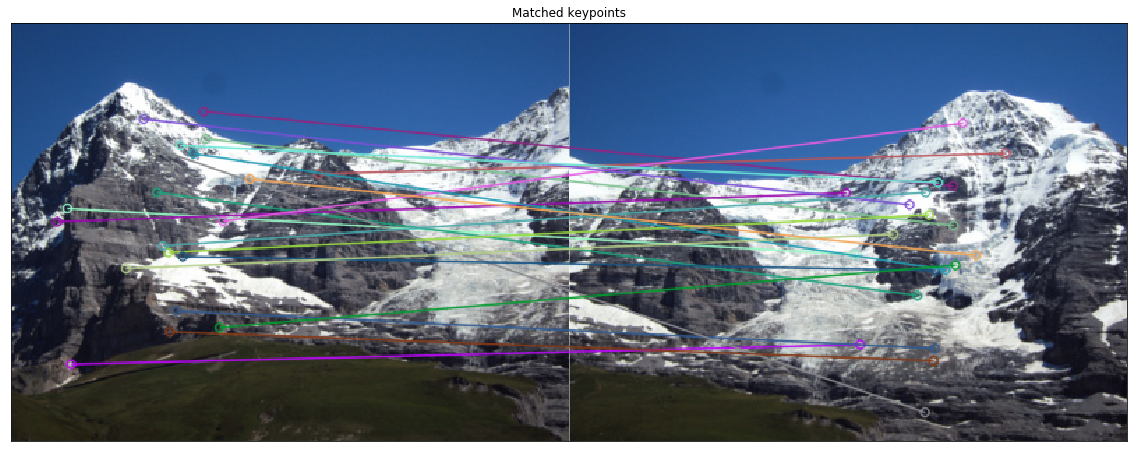

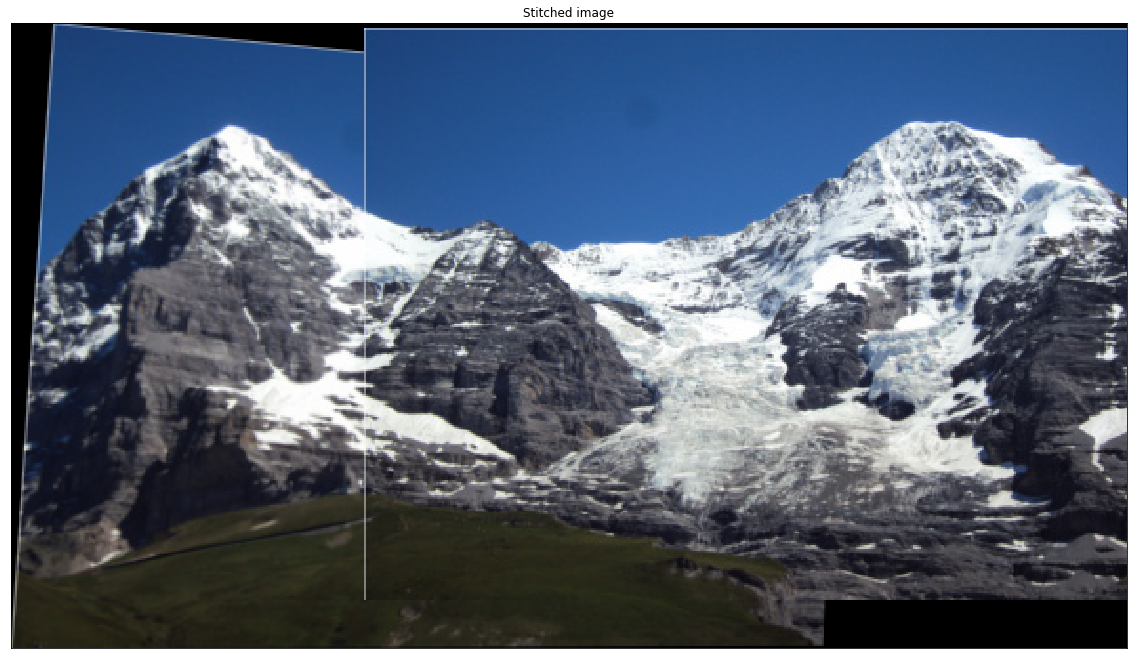

In [72]:
#import both of the images and flip them so they have the correct RGB values
image_path = "stitching_images/1Hill.JPG"
image_path2 = "stitching_images/2Hill.JPG"

image1 = cv2.imread(image_path)
image2 = cv2.imread(image_path2)

image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2RGB)
image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2RGB)

#create the sift object to be used to find descriptors and keypoints
sift = cv2.xfeatures2d.SIFT_create()

#compute both the keypoints and the descriptors on both of the given images
keypoints1, descriptors1 = sift.detectAndCompute(image1,None)
keypoints2, descriptors2 = sift.detectAndCompute(image2,None)

#create a brute-force matcher that will compute the distance between descriptors
matcher = cv2.BFMatcher()

#compute the distance between descriptors
matches = matcher.match(descriptors2,descriptors1)

#sort the matches by distance
matches = sorted(matches, key = lambda x:x.distance)

#choose the 20 smallest distances and display them on the image with connections b/w their location on both images
image3 = cv2.drawMatches(image1,keypoints1,image2,keypoints2, matches[:20], image1, flags=2)

# move the keypoints into two new lists holding the individual image's points
GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))
    
#place those points in two seperate variable holders
mp2 = np.float32([keypoints2[i].pt for (__, i) in GoodMatches])
mp1 = np.float32([keypoints1[i].pt for (i, __) in GoodMatches])

#find homography of the image
H, __ = cv2.findHomography(mp1, mp2, cv2.RANSAC, 4)

#stich the image together and return the result in to seperate images that can be placed in the same plane
result_image_1, result_image_2 = get_stitched_image(image2, image1, H)

#get the image with both images placed on the plane with the second image placed in it's original position
result_image_3 = get_stitched_image_return_one_image(image2, image1, H)



#plot the newly created image
plt.figure(figsize=(20,20))
plt.imshow(image3)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()

plt.figure(figsize=(20,20))
plt.imshow(result_image_3)
plt.title("Stitched image"), plt.xticks([]), plt.yticks([])
plt.show()


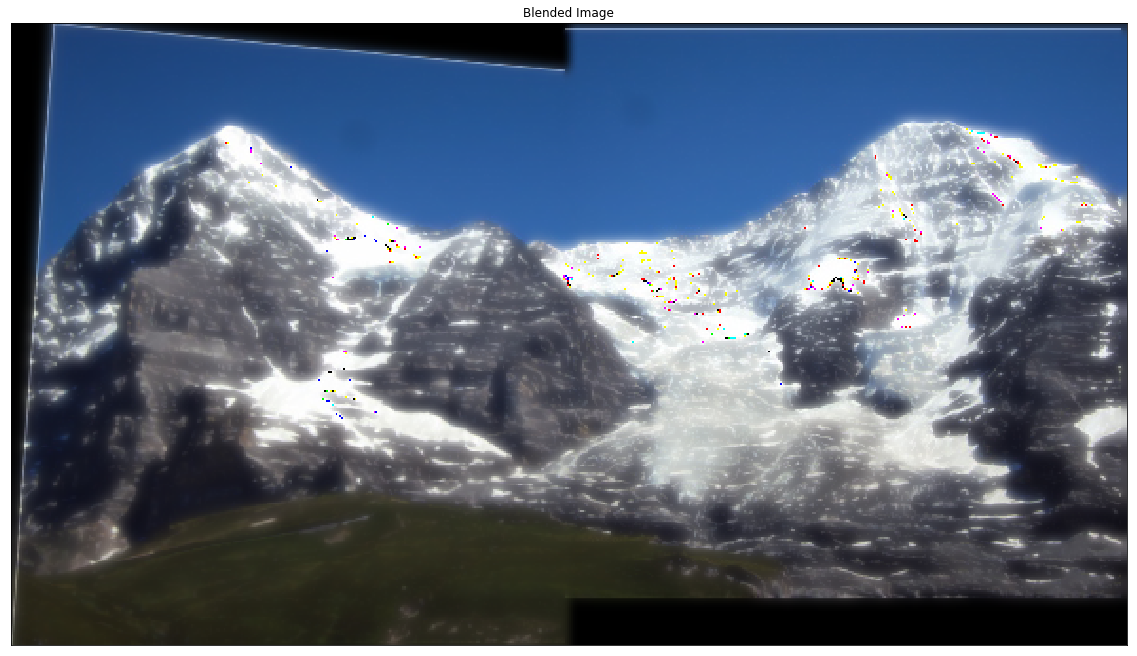

In [73]:
g_size = 255  # gaussian mask blur size
depth = 3  # pyramid depth size

# create the gaussian pyramid for image 1
G = result_image_1.copy()
gp1 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp1.append(G)

# create the gaussian pyramid for image 2
G = result_image_2.copy()
gp2 = [G]
for i in range(depth):
    G = cv2.pyrDown(G)
    gp2.append(G)

# create the laplacian pyramid for image 1
lp1 = [gp1[depth-1]]  # place the final gaussian image at the top of the laplacian pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp1[i], dstsize=(gp1[i-1].shape[1], gp1[i-1].shape[0]))
    lp = cv2.subtract(gp1[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp1.append(lp)

# create the laplacian pyramid for image 2
lp2 = [gp2[depth-1]]  # place the final gaussian image at the top of the laplacian pyramid
for i in range(depth-1,0,-1):
    # upsample lower pyramid
    hr = cv2.pyrUp(gp2[i], dstsize=(gp2[i-1].shape[1], gp2[i-1].shape[0]))
    lp = cv2.subtract(gp2[i-1], hr, cv2.CV_32F)  # subtract different levels
    lp2.append(lp)

# add the two images to each other at each level of the pyramid
LP = []
for la, lb in zip(lp1, lp2):
    row, cols, dpt = la.shape
    # stack columns (half and half)
    lp = np.hstack((la[:, :round(cols/2)], lb[:, round(cols/2):]))
    LP.append(lp)

# now reconstruct
rs = LP[0]
for i in range(1, depth):
    rs = cv2.pyrUp(rs)  # upsample current lp image
    r,c,d = LP[i].shape
    rs[:r,:c] = rs[:r,:c] + LP[i]

image12 = rs

plt.figure(figsize=(20,20))
plt.imshow(image12)
plt.title("Blended Image"), plt.xticks([]), plt.yticks([])
plt.show()


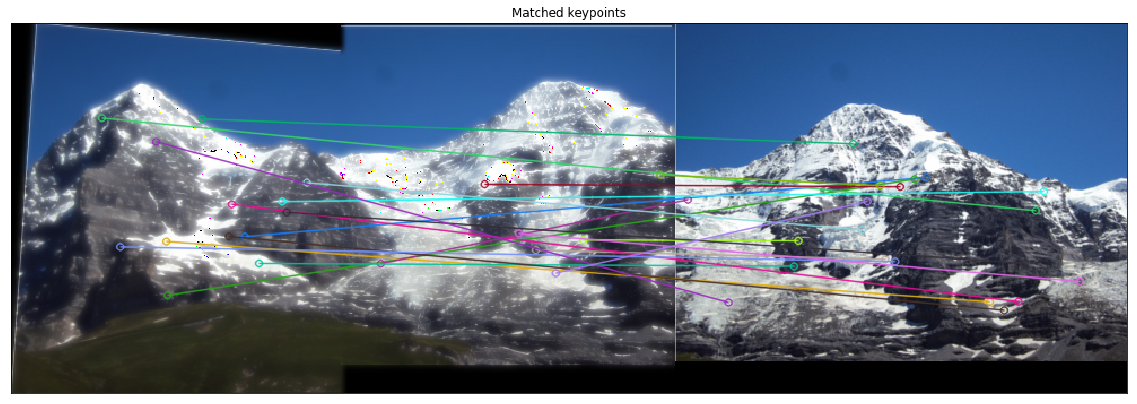

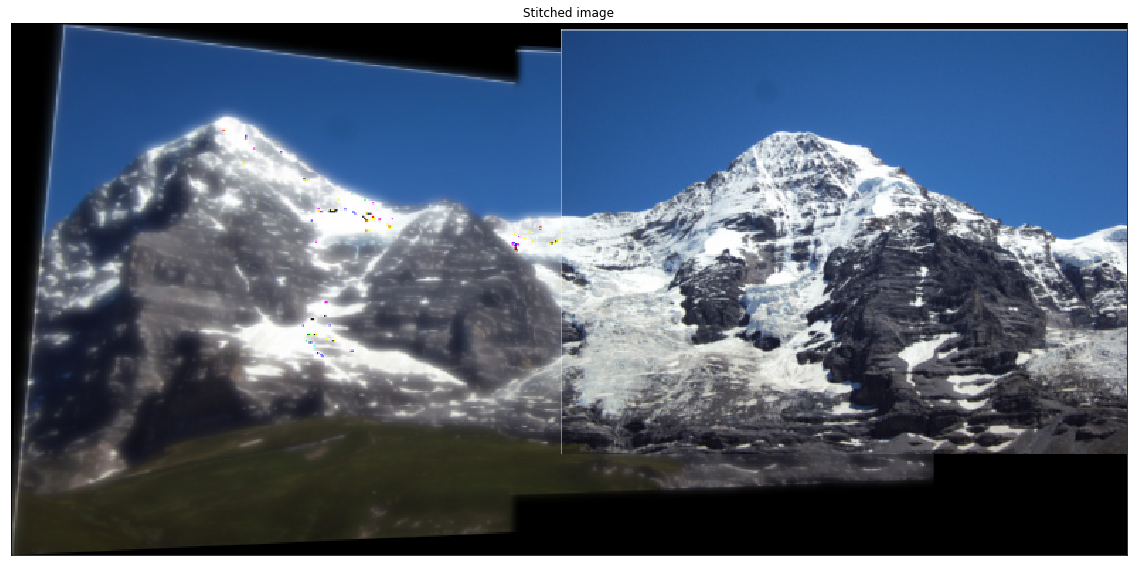

In [74]:
image_path3 = "stitching_images/3Hill.JPG"

#this is basically the same code as when computing the SIFT features and so i don't think i need to comment what
#exactly I am doing here

image3 = cv2.imread(image_path3)

image3 = cv2.cvtColor(image3, cv2.COLOR_BGR2RGB)

surf = cv2.xfeatures2d.SURF_create()

keypoints1, descriptors1 =  surf.detectAndCompute(image12,None)
keypoints2, descriptors2 =  surf.detectAndCompute(image3,None)

matcher = cv2.BFMatcher()

matches = matcher.match(descriptors2,descriptors1)

matches = sorted(matches, key = lambda x:x.distance)

matchedImage = cv2.drawMatches(image12,keypoints1,image3,keypoints2, matches[:20], image12, flags=2)

GoodMatches = []
for i, m in enumerate(matches):
    GoodMatches.append((m.trainIdx, m.queryIdx))
    
#place those points in two seperate variable holders
mp2 = np.float32([keypoints2[i].pt for (__, i) in GoodMatches])
mp1 = np.float32([keypoints1[i].pt for (i, __) in GoodMatches])

#find homography of the image
H, __ = cv2.findHomography(mp1, mp2, cv2.RANSAC, 4)

#stich the image together and return the result in to seperate images that can be placed in the same plane
result_image_1, result_image_2 = get_stitched_image(image3, image12, H)

#get the image with both images placed on the plane with the second image placed in it's original position
result_image_3 = get_stitched_image_return_one_image(image3, image12, H)

plt.figure(figsize=(20,20))
plt.imshow(matchedImage)
plt.title("Matched keypoints"), plt.xticks([]), plt.yticks([])
plt.show()


plt.figure(figsize=(20,20))
plt.imshow(result_image_3)
plt.title("Stitched image"), plt.xticks([]), plt.yticks([])
plt.show()



In [75]:
def Ramp(i_width, r_width, r_index, start, end):
   
#create the ramp which will be used to mix the two images
    a = np.zeros((i_width))
    step = (end - start) / (r_width-1)
    idx = round(r_index - (r_width / 2))
    for i in range(r_width):
        a[idx] = start + step*i
        idx += 1
    a[idx:] = 1
    return a

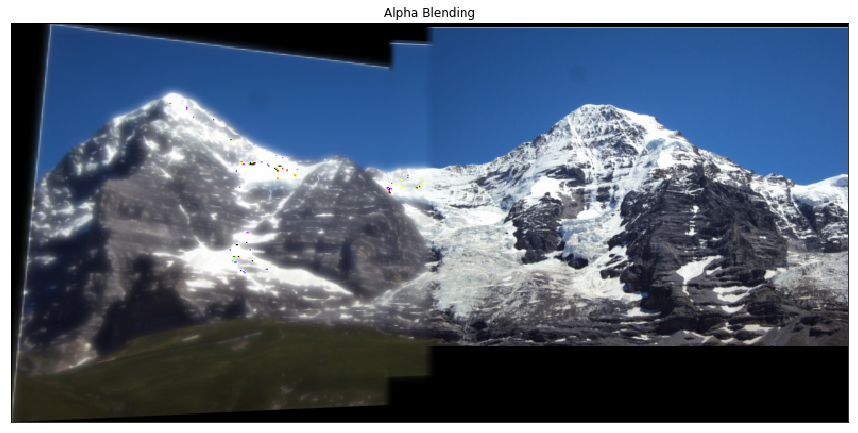

In [76]:
col, row  = result_image_1.shape[0:2]

ramp_size = 10  # alpha blending ramp size
alpha = Ramp(result_image_1.shape[1], ramp_size, round(result_image_1.shape[1]/2), 0, 1)

# Blend the two images
I_blend = (1-alpha.reshape(1,-1,1)) * result_image_1 + alpha.reshape(1,-1,1)*result_image_2
I_blend = np.uint8(I_blend)  # convert back to uint8

#plot the newly created image
plt.figure(figsize=(15,15))
plt.imshow(I_blend)
plt.title("Alpha Blending"), plt.xticks([]), plt.yticks([])
plt.show()

Reasoning Questions Start Here:

(1) The difference between SIFT and SURF points: The basic difference between SURF and SIFT for finding keypoints and descriptors is that SURF is a faster approximation of SIFT features. When one uses SURF they are sacrificing the quality of points and descriptors for the increased speed at which SURF will run. This can easily be seen by performing both SURF and SIFT on the first two images in part 1. If we do this we will see:
SIFT keypoints and descriptors 1: 1254
SIFT keypoints and descriptors 2: 1472
SURF keypoints and descriptors 1: 896
SURF keypoints and descriptors 2: 954
As can be clearly seen, there are far more keypoints and descriptors coming from SIFT than from SURF. This is gained at the expense of speed of execution.

(2) The benefit of using linear blending is very simple, it is a much more time and space effective technique to implement on images. This can be seen directly from the code. Pyramid blending requires us to create a whole host of new images and arrays which will be used to create the blended image in the end. However, when we are using linear blending the pixels inside of our ramp size are simply added together the strength of the included pixel being defined by the position of the pixels in the combined image.
In addition, in images like the ones above where we have found a clear match-point of the images it can be beneficial to use linear blending as the pyramid blending will create a filtered affect which is not needed as we only want to blend at the midpoint.

On the other hand, pyramid blending will be helpful in the case that we have two images where there are details which we would like to be sharply blended (using the example of the apple and orange blending in the tutorial, we want the two pencils to be very clearly outlined. One pencil should appear on one side of the image and the other pencil should appear on the other side) while also wanting the overall image to be blended (using the same example, we want the background of the image to be smoothly blended from one image to the other).

(3) The matches used in this code were sorted by distance so they are very similar to each other and have a low likelihood of being false matches. However, in the case of random matches, we have a good possiblity that the ones chosen will not actually be the same features and thus when we peform homography the transformation matrix will be incorrect. From this, the transformation will not cause the two images to line up when stitching occurs.

(4) The goal when performing homography should be to find a large amount of points that are actually successful matches between the two images. As we increase the amount of good matches we increase how exactly the two images will line up. If you think about starting from one match, the only thing known will be that those two points should overlay each other. As we increase the images will be overlaid more and more exactly until the two images are very well overlaid. On the other hand, as we continue to increase the amount of points used, we run a larger and larger risk of using matches that are incorrect and thus the success of the stitching will be less and less accurate. So, it is important to find a good level of points used to perform homography - this could be done by using a filter to ensure that the distance between the points is sufficiently low.